In [1]:
from sklearn.decomposition import PCA

In [2]:
from codebase.utils import load_model_by_name
from codebase.utils import generate_individual_set_loader
from codebase.utils import get_mean_variance
from codebase import utils as ut
from codebase.models.hkvae import HKVAE
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np
import torchvision
import argparse

In [3]:
from codebase.utils_c import generate_individual_set_loader
from codebase.utils_c import get_mean_variance
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np

In [4]:
parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument('--gw',             type=int, default=1,        help="Weight on the generative terms")
parser.add_argument('--cw',             type=int, default=50,      help="Weight on the class term")
parser.add_argument('--recw',            type=int, default=10,        help="Weight on the generative terms")
parser.add_argument('--kl_xy_xw',        type=int, default=10,       help="Weight on the class term")
parser.add_argument('--kl_xy_yw',        type=int, default=30,       help="Weight on the generative terms")
parser.add_argument('--iter_max',       type=int, default=10000,    help="Number of training iterations")
parser.add_argument('--iter_save',      type=int, default=5000,    help="Save model every n iterations")
parser.add_argument('--run',            type=int, default=0,        help="Run ID. In case you want to run replicates")
parser.add_argument('--train',          type=int, default=1,        help="Flag for training")
args = parser.parse_known_args()[0]

In [5]:
train_set = datasets.MNIST(
    root='../MNIST-data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

test_set = datasets.MNIST(
    root='../MNIST-data'
    ,train=False
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)
device = torch.device('cpu')
train_loader, labeled_subset, _ = ut.get_mnist_data(device, train_set, test_set, use_test_subset=True)
data_set_individual, data_loader_individual = generate_individual_set_loader(device, train_set)

In [6]:
dim = 10
model_name = "./HKVAE/model=hkvae_gw=001_cw=100_kl_xy_xw=010_kl_xy_yw=010_recw=001_run=0000"


hkvae = HKVAE(
    rec_weight=args.recw,
    kl_xy_x_weight=args.kl_xy_xw,
    kl_xy_y_weight=args.kl_xy_yw,
    gen_weight=args.gw,
    class_weight=args.cw,
    name=model_name).to(device)
load_model_by_name(hkvae, 10000)

../checkpoints\./HKVAE/model=hkvae_gw=001_cw=100_kl_xy_xw=010_kl_xy_yw=010_recw=001_run=0000\model-10000.pt
Loaded from ../checkpoints\./HKVAE/model=hkvae_gw=001_cw=100_kl_xy_xw=010_kl_xy_yw=010_recw=001_run=0000\model-10000.pt


In [7]:
# para_set = [get_mean_variance(vae, data_set_individual[i]) for i in range(10)]
# mean_mean = []
# mean_variance = []
# for i, set in enumerate(para_set):
#     print('set: {}'.format(i))
#     print("\tmean")
#     temp_mean_mean = set[0].mean(dim=0)
#     mean_mean.append(temp_mean_mean)
#     print("\t", temp_mean_mean)
#     print("\tvariance")
#     temp_mean_variance = set[1].mean(dim=0)
#     mean_variance.append(temp_mean_variance)
#     print("\t", temp_mean_variance)

# mean_mean = torch.stack(mean_mean, dim=0).detach().numpy()
# mean_variance = torch.stack(mean_variance, dim=0).detach().numpy()
    
# overall_mean = np.zeros((10, dim))
# overall_var = np.zeros((10, dim))
# for i, set in enumerate(para_set):
#     overall_mean[i], overall_var[i]  = ut.resample(30, set[0], set[1])
#     overall_var[i] = 1e-8
#     print('set: {}'.format(i))
#     print("\tmean")
#     print("\t", overall_mean[i])
#     print("\tvariance")
#     print("\t", overall_var[i])

In [8]:
# pca = PCA(n_components=2)
# newData = pca.fit_transform(overall_var)

# for i in range(newData.shape[0]):
#     plt.scatter(newData[i][0], newData[i][1], label='{i}'.format(i=i))
#     plt.legend()

In [9]:
# newData = pca.fit_transform(np.array(mean_mean))

# for i in range(newData.shape[0]):
#     plt.scatter(newData[i][0], newData[i][1], label='{i}'.format(i=i))
#     plt.legend()

In [10]:
labels = np.repeat(np.arange(10), 10)

In [11]:
y = torch.tensor(np.eye(10)[labels].reshape(-1, 10)).float()

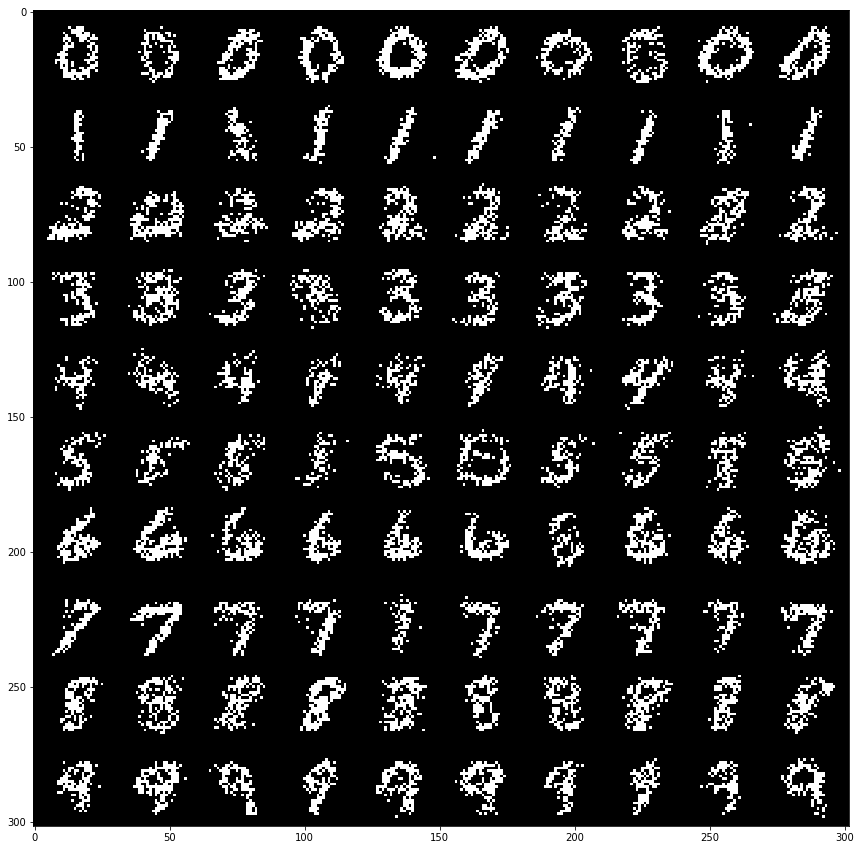

In [12]:
image = hkvae.sample_x_given_y(y)
grid = torchvision.utils.make_grid(image.reshape(-1, 1, 28, 28), nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))